## Imports

In [1]:
import utils, models_preprocessing, metrics
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import PIL.Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras import models
from keras.models import save_model, load_model
from keras.preprocessing import image
from quiver_engine import server

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Prepare data

In [2]:
data = np.load('data/imadjust.npy')
labels = np.load('labels/classification.npy')

## Model function

In [3]:
# model_function = models_preprocessing.compiledConvnet
model_function = models_preprocessing.compiledRegularizedConvnet
auroc = metrics.auroc
accuracy = metrics.accuracy
text = metrics.basicTextMetrics

In [4]:
%matplotlib inline

## Data split

In [5]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, labels, test_size=0.2)

## Train

In [6]:
## Run 1: Compiled Regularized ConvNet
model = utils.train(model_function(), 40, Xtrain, Ytrain)

Epoch 1/40
16000/16000 [==============================] - 117s 7ms/step - loss: 58.8745 - acc: 0.6776
Epoch 2/40
16000/16000 [==============================] - 117s 7ms/step - loss: 14.4488 - acc: 0.7588
Epoch 3/40
16000/16000 [==============================] - 117s 7ms/step - loss: 5.2212 - acc: 0.7890
Epoch 4/40
16000/16000 [==============================] - 117s 7ms/step - loss: 2.2023 - acc: 0.7998
Epoch 5/40
16000/16000 [==============================] - 117s 7ms/step - loss: 1.1205 - acc: 0.8107
Epoch 6/40
16000/16000 [==============================] - 117s 7ms/step - loss: 0.7104 - acc: 0.8224
Epoch 7/40
16000/16000 [==============================] - 116s 7ms/step - loss: 0.5576 - acc: 0.8246
Epoch 8/40
16000/16000 [==============================] - 117s 7ms/step - loss: 0.4849 - acc: 0.8379
Epoch 9/40
16000/16000 [==============================] - 118s 7ms/step - loss: 0.4366 - acc: 0.8486
Epoch 10/40
16000/16000 [==============================] - 117s 7ms/step - loss: 0.4088 -

## Save model, Print model summary

In [7]:
os.makedirs('models', exist_ok=True)
PATH = 'models/'

In [8]:
save_model(model, f'{PATH}model_reg_05.hdf5')

In [9]:
model = load_model(f'{PATH}model_reg_05.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 64)        2368      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1936)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               247936    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
__________

## Predictions/Probabilities for the whole dataset

In [10]:
preds = model.predict_classes(data)
probs = model.predict(data)

## Visualizing true positive's first layer activations

In [18]:
indices = [(i, preds[i]) for i in range(len(preds)) if preds[i] != labels[i]]

In [19]:
indices

[(15, array([0], dtype=int32)),
 (36, array([0], dtype=int32)),
 (53, array([0], dtype=int32)),
 (54, array([0], dtype=int32)),
 (62, array([0], dtype=int32)),
 (68, array([0], dtype=int32)),
 (91, array([0], dtype=int32)),
 (116, array([0], dtype=int32)),
 (147, array([0], dtype=int32)),
 (149, array([0], dtype=int32)),
 (166, array([0], dtype=int32)),
 (170, array([0], dtype=int32)),
 (176, array([0], dtype=int32)),
 (185, array([1], dtype=int32)),
 (208, array([0], dtype=int32)),
 (218, array([0], dtype=int32)),
 (238, array([0], dtype=int32)),
 (243, array([0], dtype=int32)),
 (245, array([0], dtype=int32)),
 (248, array([1], dtype=int32)),
 (251, array([0], dtype=int32)),
 (262, array([0], dtype=int32)),
 (266, array([0], dtype=int32)),
 (272, array([0], dtype=int32)),
 (273, array([0], dtype=int32)),
 (291, array([0], dtype=int32)),
 (304, array([0], dtype=int32)),
 (309, array([0], dtype=int32)),
 (314, array([0], dtype=int32)),
 (322, array([0], dtype=int32)),
 (343, array([0],

In [42]:
preds[185]

array([1], dtype=int32)

In [43]:
labels[185]

0.0

In [44]:
img = PIL.Image.fromarray(data[185])

In [45]:
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [46]:
print(img_tensor.shape)

(1, 101, 101, 4)


In [47]:
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [48]:
activations = activation_model.predict(img_tensor)

In [60]:
first_layer_activation = activations[3]

In [61]:
first_layer_activation.shape

(1, 11, 11, 16)

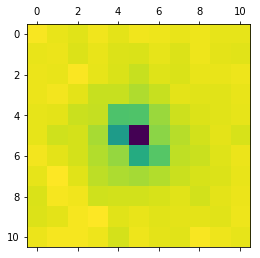

In [63]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')

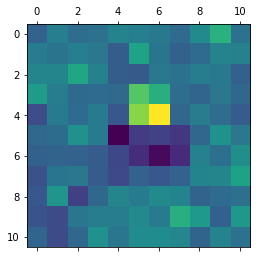

In [64]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

## Visualization of every layer, every activation

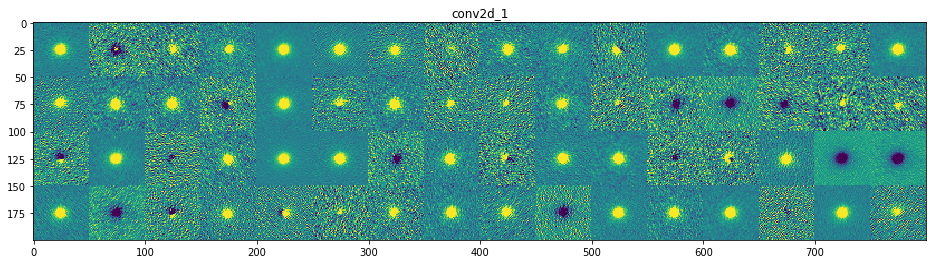

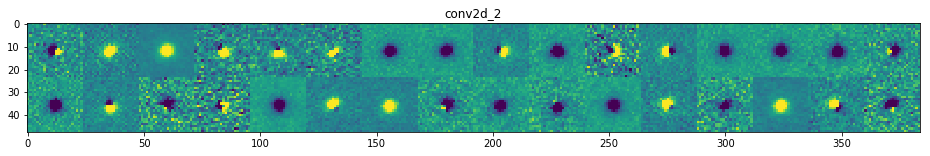

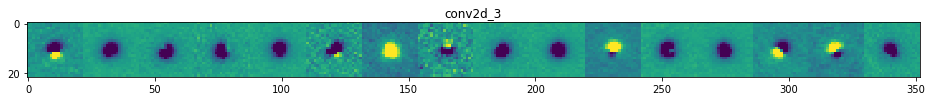

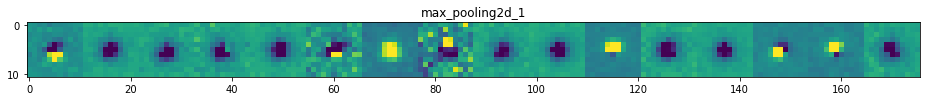

In [53]:
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col*images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col*size : (col+1)*size, row*size : (row+1)*size] = channel_image
    
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                        scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Plot confusion matrix

In [54]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [55]:
cm = confusion_matrix(labels, preds)

[[11826   153]
 [ 1254  6767]]


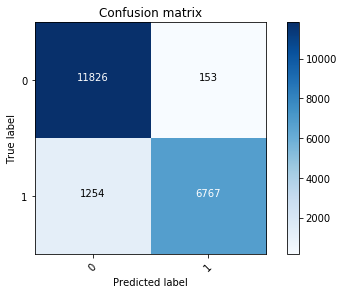

In [56]:
plot_confusion_matrix(cm, [0,1])

In [57]:
len(preds[preds==1])

6920

In [58]:
len(labels[labels==1])

8021